In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, RMSprop
import os

!nvidia-smi

Fri Aug  2 05:48:37 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    28W /  70W |   2387MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
(train_x, train_y) , (test_x, test_y) = cifar10.load_data()

def preproc_x(x, flatten = True):
  x = x / 255.0
  if flatten:
    x = x.reshape((len(x),-1))
  return x

def preproc_y(y, num_classes = 10):
  if y.shape[-1] == 1:
    y = keras.utils.to_categorical(y,num_classes)
    
  return y


x_train = preproc_x(train_x)
x_test = preproc_x(test_x)
train_y = preproc_y(train_y)
test_y = preproc_y(test_y)


print(f' x_train shape : {x_train.shape}')
print(f' train_y shape : {train_y.shape}')
print(f' x_test shape : {x_test.shape}')
print(f' test_y shape : {test_y.shape}')

 x_train shape : (50000, 3072)
 train_y shape : (50000, 10)
 x_test shape : (10000, 3072)
 test_y shape : (10000, 10)


In [0]:
def build_MLP(input_shape, output_units = 10):
  
  input_layer = keras.layers.Input(input_shape)
  x = Dense(units = 512, activation = 'relu')(input_layer)
  x = Dropout(0.2)(x)
  x = Dense(units = 512, activation = 'relu')(x)
  x = Dropout(0.2)(x)
  output_layer = Dense(units = output_units, activation = 'softmax')(x)
  
  model = keras.models.Model( inputs = [input_layer], outputs = [output_layer])
  return model

In [0]:
batch_size = 128
epochs = 10

In [0]:
mlp = build_MLP(x_train.shape[1:])
mlp.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = RMSprop())

mlp.summary()

history = mlp.fit(x_train, train_y, batch_size = batch_size, epochs = epochs, shuffle = True, validation_data = (x_test, test_y), verbose = 1)
score = mlp.evaluate(x_test, test_y, verbose = 0)
print(f' Test loss : {score[0]}')
print(f' Test accuracy : {score[1]}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 1,841,162
Trainable params: 1,841,162
Non-trainable params: 0
_________________________________________________________________


In [0]:
train_x = preproc_x(train_x, False)
test_x = preproc_x(test_x, False)

print(f' train_x shape : {x_train.shape}')
print(f' train_y shape : {train_y.shape}')
print(f' test_x shape : {test_x.shape}')
print(f' test_y shape : {test_y.shape}')

 train_x shape : (50000, 3072)
 train_y shape : (50000, 10)
 test_x shape : (10000, 32, 32, 3)
 test_y shape : (10000, 10)


In [0]:
def build_CNN(input_shape, output_units = 10):
  
  
  input_layer = keras.layers.Input(input_shape)
  
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same')(input_layer)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  x = Flatten()(x)
  x = Dense(units = 512)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(units = 256)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(units = 128)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.25)(x)
  
  output_layer = Dense(units = output_units, activation = 'softmax')(x)
  
  model = keras.models.Model( inputs = [input_layer], outputs = [output_layer])
  return model

In [0]:
dataGenerator = ImageDataGenerator( rotation_range = 10,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.1 )


dataGenerator.fit(train_x)

In [0]:
cnn_model = build_CNN(train_x.shape[1:])
sgd = keras.optimizers.SGD(lr = 0.001, momentum = 0.95, nesterov = True)
adam = keras.optimizers.Adam(lr = 0.001)
cnn_model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = adam)
cnn_model.summary()


reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, min_lr = 1e-6)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_30 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_30 (Activation)   (None, 32, 32, 64)        0         
__________

In [0]:
history = cnn_model.fit_generator(dataGenerator.flow(train_x, train_y, batch_size), epochs = 100, shuffle = True, validation_data = (test_x, test_y), steps_per_epoch=train_x.shape[0] / batch_size )

Epoch 1/100
391/390 [==============================] - 29s 74ms/step - loss: 1.6457 - acc: 0.4042 - val_loss: 1.8936 - val_acc: 0.3573
Epoch 2/100
391/390 [==============================] - 26s 66ms/step - loss: 1.2687 - acc: 0.5422 - val_loss: 1.3630 - val_acc: 0.5240
Epoch 3/100
391/390 [==============================] - 25s 65ms/step - loss: 1.0906 - acc: 0.6102 - val_loss: 1.2351 - val_acc: 0.5727
Epoch 4/100
391/390 [==============================] - 26s 65ms/step - loss: 0.9842 - acc: 0.6538 - val_loss: 1.1517 - val_acc: 0.5912
Epoch 5/100
391/390 [==============================] - 25s 64ms/step - loss: 0.9164 - acc: 0.6779 - val_loss: 0.9507 - val_acc: 0.6684
Epoch 6/100
391/390 [==============================] - 25s 64ms/step - loss: 0.8605 - acc: 0.6996 - val_loss: 0.7849 - val_acc: 0.7348
Epoch 7/100
391/390 [==============================] - 25s 64ms/step - loss: 0.8289 - acc: 0.7106 - val_loss: 0.8433 - val_acc: 0.7094
Epoch 8/100
391/390 [==============================] - 

10000/10000 [==============================] - 1s 146us/step
cnn loss : 0.6221367831468582
cnn acc : 0.815


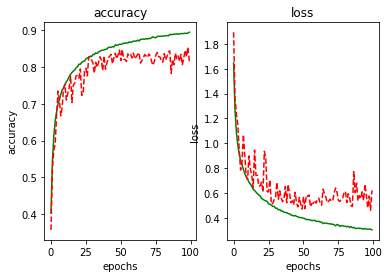

In [0]:
import matplotlib.pyplot as plt
score = cnn_model.evaluate(test_x,test_y)
print(f'cnn loss : {score[0]}')
print(f'cnn acc : {score[1]}')

plt.subplot(1,2,1)
plt.plot(history.history['acc'], '-', label = 'train_acc', color = 'g')
plt.plot(history.history['val_acc'],'--', label = 'valid_acc', color = 'r')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], '-', label = 'train_loss', color = 'g')
plt.plot(history.history['val_loss'],'--', label = 'valid_loss', color = 'r')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# 同樣運算 10 個 epochs，但 CNN 在 test data 的準確率顯著優於 DNN!
# 作業
1.請試著調整各個超參數，並說明那些超參數對於結果有明顯的影響? <br />
2.CNN 與 DNN 哪個模型的參數數量比較多? 造成參數的數量不同的原因在哪<br />

1. BatchSize : small batch size might will have much stable training process and it will have large chane to convergence. But the minimal you found might would have large chane that it is local minimal. In contrast, big batch size will make the training unstable, since your weight was updated everytime after a large amount of data. So we need to find a good batch size for our training which wont make our training drop into local minimal too esay and the weight updating will be much stabler.

2. Learning rate : Large learning rate might make our training have hard time to converge, small learning rate might need to spend lots of time on training, and it will easy to drop into local minimal.

3. filter number in Conv2D: More filters means more weights(parameters) in our NN, it might make the training time longer and the model more complex. But this means our model can learn more detail of our data, but the generalization ability will be worse.

4. Kernel size in Conv2D : Bigger kernel size means our model is learning on larger feature in image, which might make us lost some detail. But the generalization ability will become better.

5. Number of hidden layers: At the first few times of training, it might be good idea we can add the hidden as much as we can until the testing loss or testing accuracy is not improving. But the training effort(time) will be big.

6. Dropout : Normally, 0.5 will be a good start to setting our dropout rate. Dropout can make our model has better generalizatiob ability. But too big dropout rate might resut in underfitting, since most of the parameters didnt have much chance to be updated.

DNN will have much more parameters, since every pixel in the the image will have one weight in one neuron. If our image size is 32*32*3 and the dense unit is 512. Then the total parameters would be 1572864(weights) +  512(bias).